# Shiivong Kapil Birla - 30046572

# Part B - Analysing CSV Data

#  Step 1 - Import  pyspark and Initialize Spark

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import re
import nltk
import matplotlib.pyplot as plt
import os
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, min as _min, max as _max, count as _count
from pyspark.sql.types import DateType
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import udf, desc as descending
from datetime import datetime

Before proceeding, we need to set the **environent** variable.

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

In [3]:
spark_context = SparkContext.getOrCreate()

In [4]:
if spark_context is None:
    spark_context = SparkContext(master = "local[*]", appName = "Spark Assignment 1 Task A")

spark_B = SparkSession(sparkContext = spark_context)\
    .builder \
    .appName("Part B") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/Assignment1.PartB") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/Assignment1.PartB") \
    .getOrCreate()

Now that we have our Spark session up and running, we can read in the data file.

# Step 2 - Create Dataframe

Using the `read_csv()` function we can read in the file. Header is set to **true** to get the column headers.

In [5]:
data_crime = spark_B.read.csv('Crime_Statistics_SA_2010_present.csv', header = True)

In [6]:
print('The number of records in the dataframe are : ' + str(data_crime.count()))

The number of records in the dataframe are : 727408


Let's see if there are any **null values** and drop them.

In [7]:
data_crime = data_crime.dropna()

In [8]:
print('The number of records in the dataframe after dropping null values : ' + str(data_crime.count()))

The number of records in the dataframe after dropping null values : 726921


# Step 3 - Write to Database

Chaining the `.write.format()` with `.mode()` and then `.save()` using the **overwrite** mode, we can save this to the database.

In [9]:
data_crime.write.format('com.mongodb.spark.sql.DefaultSource').mode('overwrite').save()

# Step 4 - Read from Database


Using the `.read.format()` along with `.load()`m we can retrieve the records from **MongoDB**. The format which we will be using **com.mongodb.spark.sql.DefaultSource**.

In [10]:
data_crime_mongoDB = spark_B.read.format('com.mongodb.spark.sql.DefaultSource').load()

Displaying the **pyspark sql dataframe** which we just rewad from the database.

In [11]:
data_crime_mongoDB.show()

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            2|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|               5095|   23/08/2018|          POORAKA|[5d726e693163e328...|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|                Other theft|               5095|   23/08/2018|          POORAKA|[5d726e693163e328...|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|                Other theft|               5015|   23/08/2018|  

Displaying the **Schema** of our dataframe. Notice how everything is a string.

In [12]:
data_crime_mongoDB.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



# Step 5 - Calculate the Statistics of Numeric and String Columns

We will making use of various **aggregate** functions such as count, max, min etc. for this task.

For **Offence Count**, we can use the `.select()` method to select the column and appropriate aggregate function alongside it to get the statistics.

In [13]:
data_crime_mongoDB.select(
    
    _mean(col('Offence Count')).alias('mean'),
    _stddev(col('Offence Count')).alias('std'),
    _min(col('Offence Count')).alias('min'),
    _max(col('Offence Count')).alias('max'),
    _count(col('Offence Count')).alias('count')

).collect()

[Row(mean=1.171599114621809, std=0.578848526499551, min='1', max='9', count=726921)]

Similarly for the **Reported Date** column, we get the following statistics.

In [14]:
data_crime_mongoDB.select(
    
    _mean(col('Reported Date')).alias('mean'),
    _stddev(col('Reported Date')).alias('std'),
    _min(col('Reported Date')).alias('min'),
    _max(col('Reported Date')).alias('max'),
    _count(col('Reported Date')).alias('count')

).collect()

[Row(mean=None, std=None, min='1/01/2011', max='9/12/2018', count=726921)]

## Is the Reported Date correct?

In [15]:
data_crime_mongoDB.dtypes

[('Offence Count', 'string'),
 ('Offence Level 1 Description', 'string'),
 ('Offence Level 2 Description', 'string'),
 ('Offence Level 3 Description', 'string'),
 ('Postcode - Incident', 'string'),
 ('Reported Date', 'string'),
 ('Suburb - Incident', 'string'),
 ('_id', 'struct<oid:string>')]

There is a potential propblem with the **Reported Date** column, since it's a **string**, it will not give us the **correct minimum and maximum date values**!

# Step 6 - Change the Data Type of a Column

Making use of the **udf** pre-defined function, we can use the lambda function with the correct format and the `DateType()` function to convert the string into a date datatype.

In [16]:
string_to_date_func = udf(lambda given_date: datetime.strptime(given_date, '%d/%m/%Y'), DateType())

Converting the **Reported Date** column to a **datetime** format using the **udf**.

In [17]:
data_crime_mongoDB_updated = data_crime_mongoDB.withColumn('Reported Date', string_to_date_func(col('Reported Date')))

In [18]:
data_crime_mongoDB_updated.dtypes

[('Offence Count', 'string'),
 ('Offence Level 1 Description', 'string'),
 ('Offence Level 2 Description', 'string'),
 ('Offence Level 3 Description', 'string'),
 ('Postcode - Incident', 'string'),
 ('Reported Date', 'date'),
 ('Suburb - Incident', 'string'),
 ('_id', 'struct<oid:string>')]

**Reported Date** is converted to a date data type now. Using the method before, we get the **minimum and maximum** as well as the count for the Reported Date column.

In [19]:
data_crime_mongoDB_updated.select(
    
    _min(col('Reported Date')).alias('min'),
    _max(col('Reported Date')).alias('max'),
    _count(col('Reported Date')).alias('count')

).show()

+----------+----------+------+
|       min|       max| count|
+----------+----------+------+
|2010-07-01|2019-03-31|726921|
+----------+----------+------+



In [20]:
data_crime_mongoDB.show(5)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            2|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|               5095|   23/08/2018|          POORAKA|[5d726e693163e328...|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|                Other theft|               5095|   23/08/2018|          POORAKA|[5d726e693163e328...|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|                Other theft|               5015|   23/08/2018|  

# Step 7 - Preliminary Data Analysis

## Q1 : How many level 2 offences are there? Display the list of level 2 offences

We will first **count the distinct number of Offence Level 2 Description** using `.countDistinct()` and then **aggregate** using `.agg()`

In [21]:
print('The number of Level 2 Offence Categories are: ')
data_crime_mongoDB.agg(countDistinct(col('Offence Level 2 Description')).alias('Offence Level 2 Description')).show()

The number of Level 2 Offence Categories are: 
+---------------------------+
|Offence Level 2 Description|
+---------------------------+
|                          9|
+---------------------------+



In [22]:
print('Distint Level 2 Offences are : ')
data_crime_mongoDB.select('Offence Level 2 Description').distinct().show()

Distint Level 2 Offences are : 
+---------------------------+
|Offence Level 2 Description|
+---------------------------+
|       ROBBERY AND RELAT...|
|       PROPERTY DAMAGE A...|
|       SEXUAL ASSAULT AN...|
|       HOMICIDE AND RELA...|
|       ACTS INTENDED TO ...|
|       SERIOUS CRIMINAL ...|
|       OTHER OFFENCES AG...|
|       FRAUD DECEPTION A...|
|       THEFT AND RELATED...|
+---------------------------+



# Q2 : What is the number of offences against the person?

Converting the `Offence Count` variable to an integer using `IntegerType()`. 

In [23]:
from pyspark.sql.types import IntegerType
data_crime_mongoDB_updated = data_crime_mongoDB_updated.withColumn("Offence Count", data_crime_mongoDB_updated["Offence Count"].cast(IntegerType()))

We can now aggregate using `.groupBy()` and take the sum using the `.sum()` and then display the total count.

In [24]:
data_crime_mongoDB_updated.groupBy('Offence Level 1 Description').sum('Offence Count').collect()[0]

Row(Offence Level 1 Description='OFFENCES AGAINST THE PERSON', sum(Offence Count)=175480)

In [25]:
print('Total number of offences against the person are : 175480')

Total number of offences against the person are : 175480


# Q3 : How many serious criminal tresspasses with more than 1 offence count?  

Storing the Level 2 offences in `data_crime_mongoDB_Level_2` using the `.filter()` to get only the rows where **Offence Level 2 Description** is **SERIOUS CRIMINAL TRESPASS** and also **Offence Count is greater than 1**.

In [26]:
data_crime_mongoDB_Level_2 = data_crime_mongoDB.filter(data_crime_mongoDB['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS').filter(data_crime_mongoDB['Offence Count'] > 1).count()

In [27]:
print('Serious Criminal Tresspasses with more than 1 offence count is : ' + str(data_crime_mongoDB_Level_2))

Serious Criminal Tresspasses with more than 1 offence count is : 8574


# Q4 - What percentage of crimes are offences against the property? 

Filtering the data and getting only the rows which have **Offence Level 1 Description** as **OFFENCES AGAINST PROPERTY** and maiking it in a percentage format.

In [28]:
data_crime_mongoDB_Level_1 = data_crime_mongoDB.filter(data_crime_mongoDB['Offence Level 1 Description'] == 'OFFENCES AGAINST PROPERTY').count()/data_crime_mongoDB.count()
print('The percentage of offences against the property are : ', data_crime_mongoDB_Level_1*100)

The percentage of offences against the property are :  78.55213977860043


# Step 8 - Exploratory Data Analysis

# Graph 1 - Find the number of crimes per year. Plot the graph and explain your understanding of the graph

Calculating the number of crimes with respect to years. That is, we are grouping by **Reported Date** and taking a **sum** of **Offence Count**.

In [29]:
import pyspark.sql.functions as function
from pyspark.sql.functions import hour, mean, year as crime_year

data_crime_year = data_crime_mongoDB_updated.groupBy(crime_year("Reported Date").alias("Crime Year")).sum('Offence Count').collect()

This still needs to be sorted, so we apply the `sorted()` on top of it.

In [30]:
data_crime_year = sorted(data_crime_year)
data_crime_year

[Row(Crime Year=2010, sum(Offence Count)=61382),
 Row(Crime Year=2011, sum(Offence Count)=122176),
 Row(Crime Year=2012, sum(Offence Count)=112953),
 Row(Crime Year=2013, sum(Offence Count)=106761),
 Row(Crime Year=2014, sum(Offence Count)=101727),
 Row(Crime Year=2015, sum(Offence Count)=105628),
 Row(Crime Year=2016, sum(Offence Count)=107566),
 Row(Crime Year=2017, sum(Offence Count)=50144),
 Row(Crime Year=2018, sum(Offence Count)=55570),
 Row(Crime Year=2019, sum(Offence Count)=27753)]

Making two empty lists `plot_x` and `plot_y` and appending the years and their sum of offence counts onto them so that we can make a barplot.

In [31]:
plot_x = []
plot_y = []

for crime_year_iterator in data_crime_year:
    
    plot_x.append(str(crime_year_iterator[0]))
    plot_y.append(crime_year_iterator[1])

Text(0.5, 1.0, 'Crime Rate as a function of Year')

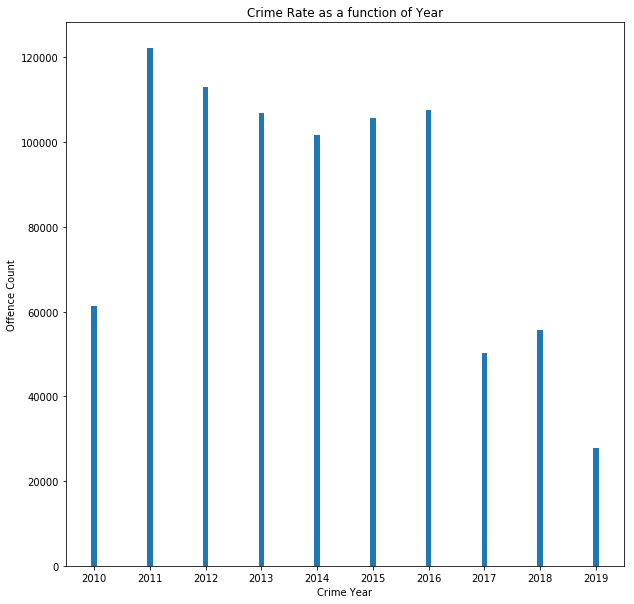

In [32]:
plt.figure(figsize=(10,10))
plt.xlabel("Crime Year")
plt.ylabel("Offence Count")
plt.bar(plot_x,plot_y, width = 0.1)
plt.title('Crime Rate as a function of Year')

Looks like that crime really saw a spike in crimes which seems to be consistent from 2011 to 2016. From 2017 it starts decreasing and it's at it's lowest in 2019.

# Graph 2 - Find the number of crimes per month. Plot the graph and explain your understanding of the graph

Same thing as above, but this time we will aggregate  based on **months, not years**.

In [33]:
import pyspark.sql.functions as function
from pyspark.sql.functions import hour, mean, year as crime_year, month as crime_month

data_crime_month = data_crime_mongoDB_updated.groupBy(crime_month("Reported Date").alias("Crime Month")).sum('Offence Count').collect()

Sorting it for better interpretation.

In [34]:
data_crime_month = sorted(data_crime_month)

Making two empty lists `plot_x` and `plot_y` and appending the years and their sum of offence counts onto them so that we can make a barplot.

In [35]:
plot_x = []
plot_y = []

for data_crime_month_iterator in data_crime_month:
    
    plot_x.append(str(data_crime_month_iterator[0]))
    plot_y.append(data_crime_month_iterator[1])

<BarContainer object of 12 artists>

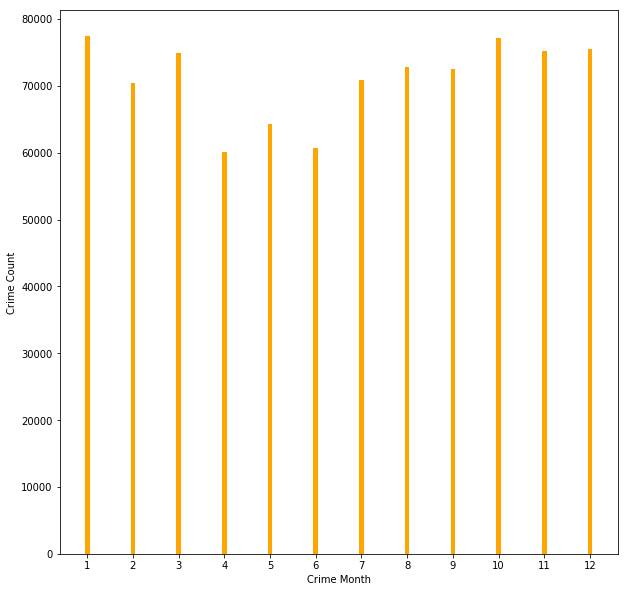

In [36]:
plt.figure(figsize=(10,10))
plt.xlabel("Crime Month")
plt.ylabel("Crime Count")
plt.bar(plot_x, plot_y, width=0.1, color = 'orange')

Seems like a pretty consisten graph, with crimes being the highest during **January and December**, maybe it's because of the **New Year**? Also, months with the lowest crime are **April, March and May**.

# Graph 3 - Where do most crimes take place? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your understanding of the graph

Grouping with respect to Suburb and Postcode, than taking a sum of Offence count.

In [37]:
data_crime_postcode = data_crime_mongoDB_updated.groupBy(['Suburb - Incident', 'Postcode - Incident']).sum('Offence Count').sort(descending('sum(Offence Count)')).collect()

Taking only the top 20 data points.

In [38]:
data_crime_postcode = data_crime_postcode[:20]

In [39]:
data_crime_postcode

[Row(Suburb - Incident='ADELAIDE', Postcode - Incident='5000', sum(Offence Count)=46701),
 Row(Suburb - Incident='PORT AUGUSTA', Postcode - Incident='5700', sum(Offence Count)=13711),
 Row(Suburb - Incident='MOUNT GAMBIER', Postcode - Incident='5290', sum(Offence Count)=13709),
 Row(Suburb - Incident='MURRAY BRIDGE', Postcode - Incident='5253', sum(Offence Count)=12919),
 Row(Suburb - Incident='MORPHETT VALE', Postcode - Incident='5162', sum(Offence Count)=12569),
 Row(Suburb - Incident='SALISBURY', Postcode - Incident='5108', sum(Offence Count)=10806),
 Row(Suburb - Incident='PORT LINCOLN', Postcode - Incident='5606', sum(Offence Count)=10779),
 Row(Suburb - Incident='ELIZABETH', Postcode - Incident='5112', sum(Offence Count)=10731),
 Row(Suburb - Incident='NOT DISCLOSED', Postcode - Incident='NOT DISCLOSED', sum(Offence Count)=9375),
 Row(Suburb - Incident='DAVOREN PARK', Postcode - Incident='5113', sum(Offence Count)=8082),
 Row(Suburb - Incident='PARAFIELD GARDENS', Postcode - Inci

Making two empty lists `plot_x` and `plot_y` and appending the years and their sum of offence counts onto them so that we can make a barplot.

In [40]:
plot_x = []
plot_y = []

for data_crime_postcode_iterator in data_crime_postcode:
    
    plot_x.append(str(data_crime_postcode_iterator[0]))
    plot_y.append(data_crime_postcode_iterator[2])

<BarContainer object of 20 artists>

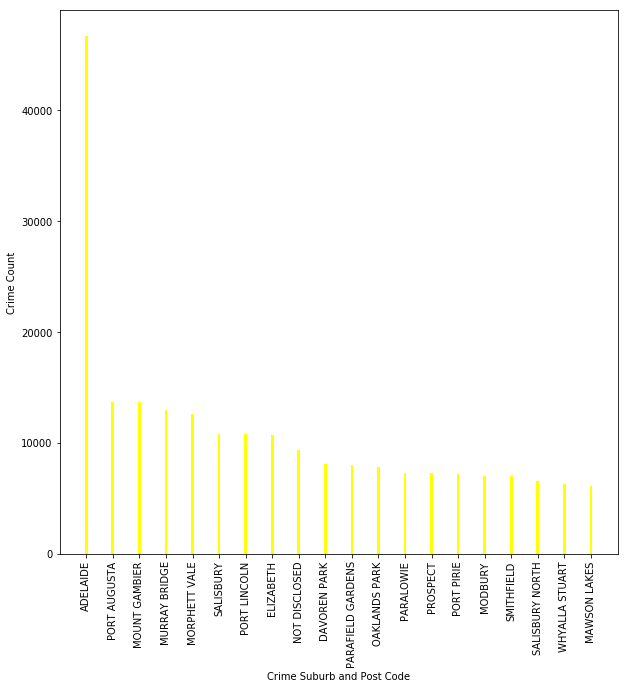

In [41]:
plt.figure(figsize=(10,10))
plt.xlabel("Crime Suburb and Post Code")
plt.ylabel("Crime Count")
plt.xticks(rotation=90)
plt.bar(plot_x, plot_y, width=0.1, color = 'yellow')

Looks like the **Adelaide** is the crime capital of the world! There's just so much more crime there than in any other place, or atleast it seems to be. Every other suburb seems to be safer as compared to Adelaide with **Mawson Lakes** being the safest in the top 20 atleast.

# References

1) https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib

2) https://stackoverflow.com/questions/38080748/convert-pyspark-string-to-date-format

3) https://matplotlib.org/2.1.1/api/_as_gen/matplotlib.pyplot.plot.html

4) https://stackoverflow.com/questions/42826502/pyspark-dataframe-group-by-filtering

5) https://forums.databricks.com/questions/9655/how-to-get-unique-values-of-a-column-in-pyspark-da.html